In [1]:
from bs4 import BeautifulSoup
import requests

import csv

import pandas as pd
import numpy as np

import datetime
import pytz

import matplotlib.pyplot as plt
%matplotlib notebook
pd.plotting.register_matplotlib_converters()

In [2]:
end = datetime.datetime.utcnow() + datetime.timedelta(days = 1)
start = datetime.datetime.utcnow() - datetime.timedelta(days = 60)

stationId = 56001
dataType = 0

url = 'https://www.ndbc.noaa.gov/station_page.php?' + \
        'station=' + str(stationId) + '&' + \
        'type=' + str(dataType) + '&' + \
        'startyear=' + str(start.year) + '&' + \
        'startmonth=' + str(start.month).zfill(2) + '&' + \
        'startday=' + str(start.day).zfill(2) + '&' + \
        'endyear=' + str(end.year) + '&' + \
        'endmonth=' + str(end.month).zfill(2) + '&' + \
        'endday=' + str(end.day).zfill(2) + '&' + \
        'submit=Submit'

req = requests.get(url)

html_doc = req.text

In [3]:
# Using BeautifulSoup to Scrape Data from NOAA National Data Buoy Center
soup = BeautifulSoup(html_doc, 'html.parser')

for element in soup.find_all('textarea'):
    data = element.text

splitData = data.split('\n')

with open('rawData.csv', 'w') as file:
    for line in splitData[:-1]:
        # Check if it is a header
        if line[0] == '#':
            continue
        # Add a line to CSV
        else:
            file.write(line)
            file.write('\n')

dataFrame = pd.read_csv('rawData.csv', header = None, delimiter = r'\s+')

In [4]:
# Date and time in UTC format
year = dataFrame[0]
month = dataFrame[1]
day = dataFrame[2]
hour = dataFrame[3]
minute = dataFrame[4]
second = dataFrame[5]

# Data type and actual height
dataType = dataFrame[6]
height = dataFrame[7]

# Change the individual date and time series to a single datetime list
date_time = []
for x in range(len(year)):
    date_time.append(datetime.datetime(year = year[x],
                                       month = month[x],
                                       day = day[x],
                                       hour = hour[x],
                                       minute = minute[x],
                                       second = second[x],
                                       tzinfo = pytz.utc))

# Re-create the dataFrame
zippedList = list(zip(date_time, height))
dataFrame = pd.DataFrame(zippedList, columns = ['datetime', 'height'])

Mean sea level is 5632.86 m


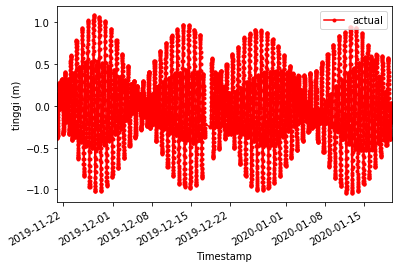

In [5]:
def plotFigure(x_act, y_act):    
    figure = plt.figure()
    axes1 = figure.add_subplot(111)
    axes1.set_ylabel('tinggi (m)')
    axes1.set_xlabel('Timestamp')
    axes1.plot(x_act, y_act, marker = '.', color = 'red', 
                  label = 'actual')
    axes1.legend(loc = 'upper right')
    axes1.set_xlim(x_act[-1], x_act[0])
    plt.gcf().autofmt_xdate()
    plt.show()

arrayDatetime = np.array(dataFrame['datetime'].to_list())
arrayRawHeight = np.array(dataFrame['height'].to_list())

averageData = np.average(arrayRawHeight)
print("Mean sea level is %.2f m" % averageData)

arrayHeight = np.subtract(arrayRawHeight, averageData)

plotFigure(arrayDatetime, arrayHeight)